# 8.2 딥드림

### 딥드림 (DeepDream)

- **딥드림(DeepDream)은 합성곱 신경망이 학습한 표현을 사용해 예술적으로 이미지를 조작하는 기법**


#### 딥드림 알고리즘
- Convnet 필터 시각화 기법과 거의 동일(5장 참고)
    - 특정 필터의 시각화를 극대화 하기 위해 입력에 경사 상승법을 적용
    
    
- 전체 층의 활성화를 최대화
    - 한번에 많은 특성을 섞어서 시각화
    
    
- 실제 이미지를 사용해서 시각화
    - 시각 패턴을 바탕으로 이미지의 요소들을 에술적인 스타일로 왜곡시킴
    
    
- 입력 이미지는 시각 품질을 높이기 위해 여러 다른 스케일(옥타브(octave)라고 부름)로 처리
    - 옥타브(octave)는 이미지 크기를 일정한 비율로 연속해서 줄이거나 늘리는 방식을 말함

## 8.2.1 케라스 딥드림 구현

### 모델 가져오기

- ImageNet에서 훈련된 인셉션 모델을 사용
    - 원래 딥드림에서 사용한 모델이므로 딥드림 이미지를 잘 만듦
    

- 인셉션 모델에서 임의로 4개의 층을 선택
    - 해당 층의 모든 필터를 활성화

In [1]:
# tensorflow.keras.backend 함수 쓰면 gradients()에서 에러남(텐서플로에서는 GradientTape()를 씀)
# 텐서플로의 GradientTape를 사용한 딥드림 예제 아래 링크 참고
# https://www.tensorflow.org/tutorials/generative/deepdream

# 여기서만 케라스를 사용함
import keras
from keras.applications import inception_v3
from keras import backend as K

# 모든 훈련 연산을 비활성화 (모델을 훈련하지 않음)
K.set_learning_phase(0)

# 마지막 분류기 제외한 Inception V3 모델 가져오기
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)

model.summary()

Using TensorFlow backend.


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [2]:
# 딥드림에서 활성화 할 층 설정
# 각 층의 활성화가 기여할 가중치도 같이 설정

layer_contributions = {
    'mixed2':0.2,
    'mixed3':3.,
    'mixed4':2.,
    'mixed5':1.5,
}

### 손실 함수 정의

#### 경사 상승법 적용
- 손실함수 : 활성화(층의 출력)의 L2 Norm의 제곱에 대한 가중치 합
- gradient : 입력 이미지에 대한 위 손실함수의 변화

In [3]:
# 층 이름별 딕셔너리
layer_dict = dict([ (layer.name, layer) for layer in model.layers ])

# 손실 값 초기화
loss = K.variable(0.)

# 딥드림에 적용할 4개의 층에 대해서 손실함수 정의
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output
    
    # K.prod() : 텐서의 모든 원소를 곱함
    # 활성화(출력)의 크기 원소들을 모두 곱해서 원소 개수를 구함(정규화를 위해)
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    
    # 손실함수 : L2 Norm의 제곱(이미지 테두리 제외)
    # coeff : 가중치 적용
    # scaling : 정규화
    loss = loss + ( coeff * K.sum(K.square(activation[:, 2:-2, 2:-2, :])) ) / scaling

In [4]:
# 입력 이미지
dream = model.input

# gradient 정의
grads = K.gradients(loss, [dream])[0]

# gradient 정규화 (이 기교가 중요함)
# gradient의 모든 원소의 절댓값에 평균을 한 값으로 나눠줌
# 최소 10^-7로 나누게 한거는 divide by zero 막으려고 한 것 같음
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)
    

# 이미지를 입력으로 loss와 gradient를 반환하는 Function 객체 생성
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)


def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = fetch_loss_and_grads([x])
        
        if max_loss is not None and loss_value > max_loss:
            break
        
        print('...', i, '번째 손실 :', loss_value)
        x += step * grad_values
    
    return x

### 딥드림 알고리즘

- 이미지 스케일을 점차 늘리며 연속적으로 경사 상승법을 수행
    - 경사 상승법 실행 후 이미지 크기를 40% 증가(1.4배)
    - 예제에서는 350x350 이미지를 178x178로 줄인 후 40%씩 두번 늘리며 총 3번 딥드림 수행
        1. 178x178
        2. 250x250
        3. 350x350


- 이미지 스케일을 늘린 후 손실된 이미지의 디테일을 재주입
    - 원본 이미지를 알고 있기 때문에 가능함

In [12]:
# 유틸리티 함수들

import cv2
import numpy as np
import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1, 
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    res_img = deprocess_image(np.copy(img))
    cv2.imwrite(fname, res_img)
    

# 사진을 Inception V3의 텐서 포맷으로 변환
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    
    return img


# 넘파이 배열을 이미지 포맷으로 변환
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
        
    else :
        x = x.reshape((x.shape[1], x.shape[2], 3))
        
    
    # inception v3의 전처리 과정
    # 1. 픽셀값을 255로 나눠서 0~1로 만듦
    # 2. 0.5를 빼서 -0.5~0.5사이로 변환
    # 3. 2를 곱해서 -1~1사이로 변환
    # 위의 전처리 과정을 다시 반대로 수행해서 이미지형태로 다시 복원시킴
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x

In [13]:
import numpy as np

step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20

max_loss = 10.

base_image_path = './datasets/original_photo_deep_dream.jpg'

img = preprocess_image(base_image_path)

# 이미지 스케일 크기를 정의한 튜플 리스트 생성
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    # 원본 이미지 크기를 40%씩 줄이려고 1.4로 계속해서 나눠줌
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
    
successive_shapes = successive_shapes[::-1] # 작은 이미지에서 큰 이미지 순으로 하기 위해 뒤집음


# 시작 이미지를 위해 가장 작은 스케일로 변환
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('처리할 이미지 크기 :', shape)
    
    # 이미지의 스케일을 높임 (이미지 디테일 손실)
    img = resize_img(img, shape)
    
    # 경사 상승법 적용
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    
    # 작게 줄인 원본 이미지를 한단계 높은 스케일로 변환한 것(저해상도 버전)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    
    # 위에서 변환한 스케일로 원본 이미지를 변환(고해상도 버전)
    same_size_original = resize_img(original_img, shape)
    
    # 위 두 이미지의 차이를 계산한 것이 손실된 이미지의 디테일
    lost_detail = same_size_original - upscaled_shrunk_original_img
    
    # 손실된 이미지의 디테일을 주입해줌
    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='./datasets/dream_at_scale_' + str(shape) + '.png')

처리할 이미지 크기 : (178, 178)
... 0 번째 손실 : 0.6321542
... 1 번째 손실 : 0.9662367
... 2 번째 손실 : 1.406683
... 3 번째 손실 : 1.9307163
... 4 번째 손실 : 2.4420674
... 5 번째 손실 : 3.0432088
... 6 번째 손실 : 3.5341105
... 7 번째 손실 : 4.05229
... 8 번째 손실 : 4.603054
... 9 번째 손실 : 5.099369
... 10 번째 손실 : 5.6979914
... 11 번째 손실 : 6.1996517
... 12 번째 손실 : 6.7422867
... 13 번째 손실 : 7.162565
... 14 번째 손실 : 7.6438293
... 15 번째 손실 : 8.017137
... 16 번째 손실 : 8.571226
... 17 번째 손실 : 9.050076
... 18 번째 손실 : 9.361426
... 19 번째 손실 : 9.950533
처리할 이미지 크기 : (250, 250)
... 0 번째 손실 : 2.1433942
... 1 번째 손실 : 3.4583678
... 2 번째 손실 : 4.5674925
... 3 번째 손실 : 5.5853915
... 4 번째 손실 : 6.49675
... 5 번째 손실 : 7.318139
... 6 번째 손실 : 8.160001
... 7 번째 손실 : 8.963969
... 8 번째 손실 : 9.803022
처리할 이미지 크기 : (350, 350)
... 0 번째 손실 : 2.326312
... 1 번째 손실 : 3.5426712
... 2 번째 손실 : 4.8618374
... 3 번째 손실 : 6.4424453
... 4 번째 손실 : 8.570293


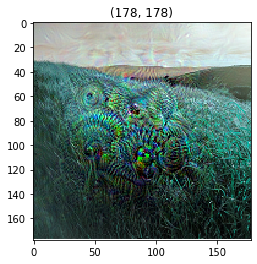

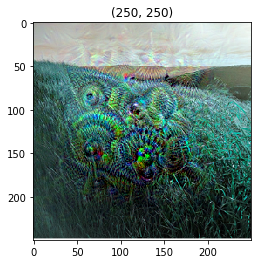

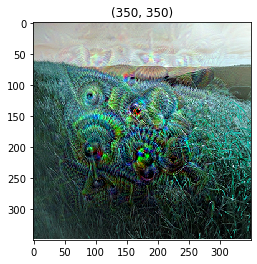

In [19]:
# 결과 이미지 출력

import os
import matplotlib.pyplot as plt

for shape in successive_shapes:
    fname = os.path.join('./datasets', 'dream_at_scale_{}.png'.format(shape))
    img = cv2.imread(fname)
    img = np.array(img).astype('float32') / 255.
    
    plt.figure()
    plt.title(shape)
    plt.imshow(img)

### 결과 분석

- 네트워크의 하위 층을 사용하였으므로 비교적 덜 추상적인 기하학적 패턴이 생겼음

## 8.2.2 정리

- 딥드림은 네트워크가 학습한 표현을 기반으로 컨브넷을 거꾸로 실행하여 재미있고 신기한 입력 이미지를 생성함
    - `layer_contributions` 파라미터를 조절하면(새로운 층과 가중치 조합)을 설정하면 새로운 이미지를 얻을 수 있음
        - 네트워크의 **하위 층**을 사용할 경우 덜 추상적인 **기하학적 패턴**이 많이 생김
        - 네트워크의 **상위 층**을 사용할 경우 강아지의 눈, 새의 깃털 같은 ImageNet에 등장하는 **물체를 기반으로 한 시각 패턴**들이 많이 생김
        
        
- 딥드림은 이미지 모델에 국한되지 않으며 음성, 음악에도 적용될 수 있음